In [39]:
import logging
from time import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import density

%matplotlib inline

In [5]:
def prepararDados(usarHashing=True):
    DIR_DATASET = r'C:\Users\Daniel.Vale\Personal\PBDDC\TCC\Projeto\datasets\\'
    ARQUIVO_PROPOSICOES = f'{DIR_DATASET}\\proposicoes.csv'
    ARQUIVO_TEMAS = f'{DIR_DATASET}\\temas.csv'
    colunasPreposicoes = ['id', 'uri', 'ementa']
    colunasTemas = ['uriProposicao', 'siglaTipo', 'codTema', 'tema']

    print('_' * 80)
    print(f'Carregando dados datasets: \nproposições ==> {ARQUIVO_PROPOSICOES}\ntemas==> {ARQUIVO_TEMAS} ')

    print('_' * 80)
    print(f'Criando dataframes:')

    dfPreposicoes = pd.read_csv(ARQUIVO_PROPOSICOES, sep='|', low_memory=False, usecols=colunasPreposicoes)
    print(f'Qtd. de proposições: {len(dfPreposicoes)}')

    dfTemas = pd.read_csv(ARQUIVO_TEMAS, sep='|', low_memory=False, usecols=colunasTemas)
    print(f'Qtd. de proposições classificadas: {len(dfTemas)}')

    print('_' * 80)
    print(f'Fazendo merge das preposições com as preposicões com temas')

    dfPreposicoesTemas = pd.merge(dfTemas, dfPreposicoes, left_on='uriProposicao', right_on='uri')
    print(f'Qtd. de proposições com temas: {len(dfPreposicoesTemas)}')

    print('_' * 80)
    print('Criando dataframe para o modelo de aprendizado')

    dfClassificacao = dfPreposicoesTemas[['ementa', 'tema']]
    print(dfClassificacao.describe())

    print("." * 80)
    print('Lista de temas')
    print(pd.unique(dfClassificacao['tema']))

    print('_' * 80)
    print('Dividindo dados de treino e de teste para o modelo de aprendizado')
    ementas = dfPreposicoesTemas['ementa'].values.astype('U')
    temas = dfPreposicoesTemas['tema'].values.astype('U')
    target_names = pd.unique(temas)

    ementas_treino, ementas_teste, temas_treino, temas_test = train_test_split(ementas, temas, test_size=0.33)

    print(f'Divisão dos dados: Treino={len(ementas_treino) / len(ementas)} | Teste={len(ementas_teste) / len(ementas)}')
    print(f'Dados de treino: Ementas={len(ementas_treino)} | Temas={len(temas_treino)}')
    print(f'Dados de teste: Ementas={len(ementas_teste)} | Temas={len(temas_test)}')

    print('_' * 80)
    print(f'Vetorizando o texto das ementas [utilizando Hashing={usarHashing}]')
    stopWords = pd.read_csv(f'{DIR_DATASET}\\stop_words.csv', usecols=['stop_words']) \
    .replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["", ""])
    listaStopWords = stopWords['stop_words'].values.tolist()
    print(f'Total de stopwords: {len(stopWords)}')

    inicio = time()
    
    if (usarHashing):
        vetorizador = HashingVectorizer(stop_words=listaStopWords, alternate_sign=False, n_features=2 ** 4)
        X_train = vetorizador.transform(ementas_treino)
    else:
        vetorizador = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=listaStopWords)
        X_train = vetorizador.fit_transform(ementas_treino)

    duracao = time() - inicio

    print(f'Vetorização dados de treino finalizada em {duracao}0.2f s')
    print("No. de exemplos (n_samples): %d, No. Features (n_features): %d" % X_train.shape)

    print('.' * 80)
    inicio = time()
    X_test = vetorizador.transform(ementas_teste)
    duracao = time() - inicio
    print(f'Vetorização dados de teste finalizada em {duracao}0.2f s')
    print("No. de exemplos (n_samples): %d, No. Features (n_features): %d" % X_test.shape)

    return X_train, temas_treino, X_test, temas_test, target_names

In [60]:
def executarModeloClassificacao(rotulo,classificador, X_treino, y_treino, X_teste, y_teste, target_names, imprimirRelatorio=False,
                                imprimirMatrizConfusao=False):
    nomeClassificador = f'{str(classificador).split("(")[0]} - {rotulo}'
    print('.' * 80)
    print(f'Treinando o modelo: {classificador}')
    inicio = time()
    classificador.fit(X_treino, y_treino)
    tempoTreino = time() - inicio
    print(f'Tempo de treinamento: {tempoTreino:.2f} segundos')

    inicio = time()
    predicao = classificador.predict(X_teste)
    tempoTeste = time() - inicio
    print(f'Tempo de teste: {tempoTeste:.2f} segundos')

    acuracia = metrics.accuracy_score(y_teste, predicao)
    matrizConfusao = metrics.confusion_matrix(y_teste, predicao)
    relatorioClassificao = metrics.classification_report(y_teste,
                                                       predicao,
                                                       target_names=target_names,
                                                       labels=target_names,
                                                        zero_division=0)

    print(f'Acurácia: {acuracia * 100:.2f}')

    print('-' * 80)
    
    print("RELATÓRIO DE CLASSIFICAÇÃO:")
    print(relatorioClassificao)
    
    print('-' * 80)
    
    print('-' * 80)
    print('MATRIZ DE CONFUSAO')
    
    plt.matshow(matrizConfusao)
    plt.title("Matriz de confusão")
    plt.colorbar()
    plt.ylabel("Classificações corretas")
    plt.xlabel("Classificações obtidas")
    plt.show()
    
    print('-' * 80)
    print('.' * 80)

    return nomeClassificador, acuracia, tempoTreino, tempoTeste, relatorioClassificao, matrizConfusao

In [61]:
resultados = []
X_train, temas_treino, X_test, temas_test, target_names = prepararDados(False)


________________________________________________________________________________
Carregando dados datasets: 
proposições ==> C:\Users\Daniel.Vale\Personal\PBDDC\TCC\Projeto\datasets\\\proposicoes.csv
temas==> C:\Users\Daniel.Vale\Personal\PBDDC\TCC\Projeto\datasets\\\temas.csv 
________________________________________________________________________________
Criando dataframes:
Qtd. de proposições: 560575
Qtd. de proposições classificadas: 176410
________________________________________________________________________________
Fazendo merge das preposições com as preposicões com temas
Qtd. de proposições com temas: 176410
________________________________________________________________________________
Criando dataframe para o modelo de aprendizado
                                                   ementa          tema
count                                              176404        176410
unique                                             126033            32
top     Altera a Lei Complem

## Executar todos os modelos de classificação

SGD panalidade l2
................................................................................
Treinando o modelo: SGDClassifier(max_iter=50)
Tempo de treinamento: 5.36 segundos
Tempo de teste: 0.05 segundos
Acurácia: 60.23
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.50      0.50      0.50      3763
                        Estrutura Fundiária       0.49      0.55      0.52       811
      Energia, Recursos Hídricos e Minerais       0.59      0.74      0.66      1635
                   Arte, Cultura e Religião       0.53      0.46      0.49       709
                      Administração Pública       0.53      0.45      0.49      5446
                         Trabalho e Emprego       0.57      0.55      0.56      2851
           Direito Penal e Processual Penal       0.60      0.73   

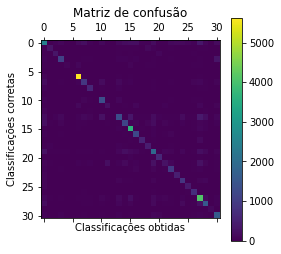

--------------------------------------------------------------------------------
................................................................................
SGD panalidade l1
................................................................................
Treinando o modelo: SGDClassifier(max_iter=50, penalty='l1')
Tempo de treinamento: 6.55 segundos
Tempo de teste: 0.04 segundos
Acurácia: 52.06
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.56      0.39      0.46      3763
                        Estrutura Fundiária       0.59      0.33      0.42       811
      Energia, Recursos Hídricos e Minerais       0.59      0.67      0.63      1635
                   Arte, Cultura e Religião       0.56      0.46      0.50       709
                      Administração Pública       0.51      0

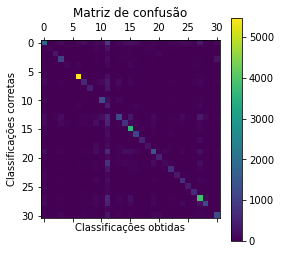

--------------------------------------------------------------------------------
................................................................................
Linear SVC penalidade l2
................................................................................
Treinando o modelo: LinearSVC(dual=False, tol=0.001)
Tempo de treinamento: 41.84 segundos
Tempo de teste: 0.03 segundos
Acurácia: 56.64
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.45      0.45      0.45      3763
                        Estrutura Fundiária       0.52      0.55      0.53       811
      Energia, Recursos Hídricos e Minerais       0.59      0.63      0.61      1635
                   Arte, Cultura e Religião       0.47      0.43      0.45       709
                      Administração Pública       0.48      0

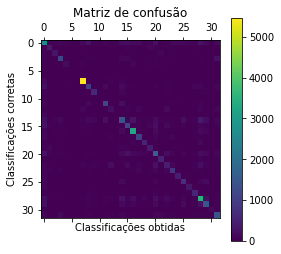

--------------------------------------------------------------------------------
................................................................................
Linear SVC penalidade l1
................................................................................
Treinando o modelo: LinearSVC(dual=False, penalty='l1', tol=0.001)
Tempo de treinamento: 76.36 segundos
Tempo de teste: 0.04 segundos
Acurácia: 59.37
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.48      0.48      0.48      3763
                        Estrutura Fundiária       0.52      0.55      0.54       811
      Energia, Recursos Hídricos e Minerais       0.61      0.68      0.64      1635
                   Arte, Cultura e Religião       0.49      0.46      0.48       709
                      Administração Pública    

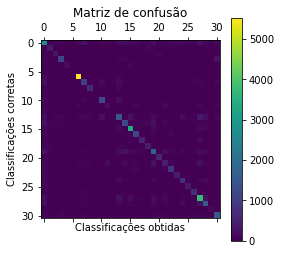

--------------------------------------------------------------------------------
................................................................................
Ridge Classifier
................................................................................
Treinando o modelo: RidgeClassifier(solver='sag', tol=0.01)


c:\program files\python39\lib\site-packages\sklearn\linear_model\_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


Tempo de treinamento: 35.45 segundos
Tempo de teste: 0.05 segundos
Acurácia: 60.02
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.49      0.50      0.50      3763
                        Estrutura Fundiária       0.52      0.55      0.53       811
      Energia, Recursos Hídricos e Minerais       0.60      0.70      0.65      1635
                   Arte, Cultura e Religião       0.52      0.46      0.49       709
                      Administração Pública       0.51      0.50      0.50      5446
                         Trabalho e Emprego       0.57      0.54      0.56      2851
           Direito Penal e Processual Penal       0.62      0.67      0.64      1858
                                   Economia       0.52      0.48      0.50      2540
                                      Saúd

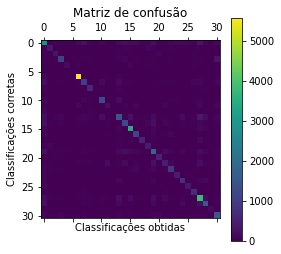

--------------------------------------------------------------------------------
................................................................................
Perceptron
................................................................................
Treinando o modelo: Perceptron(max_iter=50)
Tempo de treinamento: 4.88 segundos
Tempo de teste: 0.04 segundos
Acurácia: 48.23
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.37      0.33      0.35      3763
                        Estrutura Fundiária       0.50      0.41      0.45       811
      Energia, Recursos Hídricos e Minerais       0.56      0.49      0.52      1635
                   Arte, Cultura e Religião       0.39      0.37      0.38       709
                      Administração Pública       0.40      0.42      0.41      5446


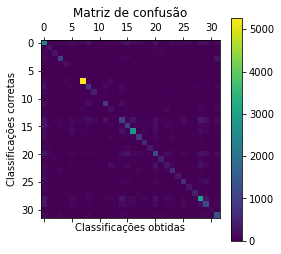

--------------------------------------------------------------------------------
................................................................................
Passive-Aggressive
................................................................................
Treinando o modelo: PassiveAggressiveClassifier(max_iter=50)
Tempo de treinamento: 9.31 segundos
Tempo de teste: 0.03 segundos
Acurácia: 50.96
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.38      0.40      0.39      3763
                        Estrutura Fundiária       0.48      0.46      0.47       811
      Energia, Recursos Hídricos e Minerais       0.57      0.51      0.54      1635
                   Arte, Cultura e Religião       0.42      0.38      0.40       709
                      Administração Pública       0.45      

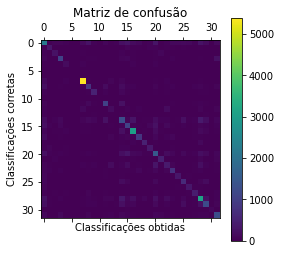

--------------------------------------------------------------------------------
................................................................................
kNN
................................................................................
Treinando o modelo: KNeighborsClassifier(n_neighbors=10)
Tempo de treinamento: 0.16 segundos
Tempo de teste: 222.98 segundos
Acurácia: 39.53
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.25      0.34      0.29      3763
                        Estrutura Fundiária       0.48      0.37      0.42       811
      Energia, Recursos Hídricos e Minerais       0.69      0.31      0.43      1635
                   Arte, Cultura e Religião       0.53      0.25      0.34       709
                      Administração Pública       0.27      0.41      0.32   

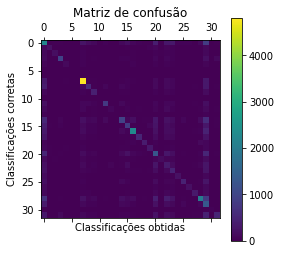

--------------------------------------------------------------------------------
................................................................................
NearestCentroid 
................................................................................
Treinando o modelo: NearestCentroid()
Tempo de treinamento: 0.24 segundos
Tempo de teste: 0.05 segundos
Acurácia: 49.97
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.49      0.37      0.42      3763
                        Estrutura Fundiária       0.37      0.39      0.38       811
      Energia, Recursos Hídricos e Minerais       0.62      0.58      0.60      1635
                   Arte, Cultura e Religião       0.54      0.44      0.48       709
                      Administração Pública       0.43      0.31      0.36      5446


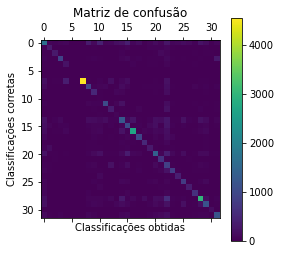

--------------------------------------------------------------------------------
................................................................................
 Naive Bayes - MultinomialNB
................................................................................
Treinando o modelo: MultinomialNB(alpha=0.01)
Tempo de treinamento: 0.57 segundos
Tempo de teste: 0.03 segundos
Acurácia: 55.96
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.43      0.50      0.46      3763
                        Estrutura Fundiária       0.50      0.53      0.52       811
      Energia, Recursos Hídricos e Minerais       0.62      0.64      0.63      1635
                   Arte, Cultura e Religião       0.50      0.38      0.43       709
                      Administração Pública       0.45      0.52 

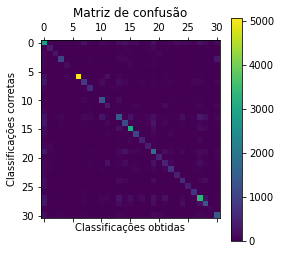

--------------------------------------------------------------------------------
................................................................................
 Naive Bayes - BernoulliNB
................................................................................
Treinando o modelo: BernoulliNB(alpha=0.01)
Tempo de treinamento: 0.59 segundos
Tempo de teste: 0.06 segundos
Acurácia: 54.65
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.47      0.44      0.45      3763
                        Estrutura Fundiária       0.43      0.56      0.48       811
      Energia, Recursos Hídricos e Minerais       0.62      0.63      0.63      1635
                   Arte, Cultura e Religião       0.44      0.45      0.45       709
                      Administração Pública       0.50      0.40     

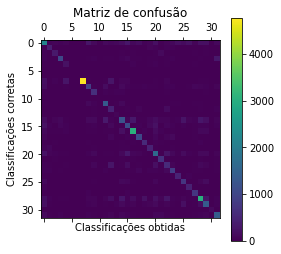

--------------------------------------------------------------------------------
................................................................................
 Naive Bayes - ComplementNB
................................................................................
Treinando o modelo: ComplementNB(alpha=0.01)
Tempo de treinamento: 0.58 segundos
Tempo de teste: 0.04 segundos
Acurácia: 57.29
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.46      0.52      0.49      3763
                        Estrutura Fundiária       0.51      0.52      0.51       811
      Energia, Recursos Hídricos e Minerais       0.56      0.71      0.63      1635
                   Arte, Cultura e Religião       0.48      0.36      0.41       709
                      Administração Pública       0.50      0.47   

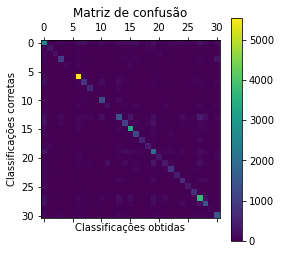

--------------------------------------------------------------------------------
................................................................................
LinearSVC c/ feature selection
................................................................................
Treinando o modelo: Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
Tempo de treinamento: 92.41 segundos
Tempo de teste: 0.07 segundos
Acurácia: 56.90
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.45      0.45      0.45      3763
                        Estrutura Fundiária       0.52      0.54      0.53       811
      Energia, Recursos 

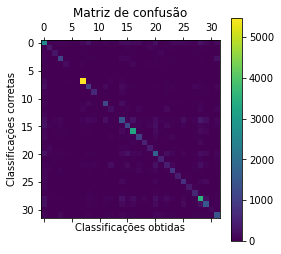

--------------------------------------------------------------------------------
................................................................................


In [34]:
for classificador, nome in (
  (SGDClassifier(alpha=0.0001, max_iter=50, penalty='l2'), 'SGD panalidade l2'),
  (SGDClassifier(alpha=0.0001, max_iter=50, penalty='l1'), 'SGD panalidade l1'),
  (LinearSVC(penalty='l2', dual=False, tol=1e-3), 'Linear SVC penalidade l2'),
  (LinearSVC(penalty='l1', dual=False, tol=1e-3), 'Linear SVC penalidade l1'),
  (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
  (Perceptron(max_iter=50), "Perceptron"),
  (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
  (KNeighborsClassifier(n_neighbors=10), "kNN"),
  # (RandomForestClassifier(), "Random forest"),
  # (MLPClassifier(max_iter=100, random_state=1, verbose=False), 'MLP Classifier'),
  (NearestCentroid(), 'NearestCentroid '),
  (MultinomialNB(alpha=0.01), ' Naive Bayes - MultinomialNB'),
  (BernoulliNB(alpha=0.01), ' Naive Bayes - BernoulliNB'),
  (ComplementNB(alpha=0.01), ' Naive Bayes - ComplementNB'),
  (Pipeline(
    [
      (
          "feature_selection",
          SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
      ),
      ("classification", LinearSVC(penalty="l2")),
    ]
  ), 'LinearSVC c/ feature selection')
):
    print("=" * 80)
    print(nome)
    resultados.append(executarModeloClassificacao(nome,classificador, X_train, temas_treino, X_test, temas_test, target_names))

................................................................................
Treinando o modelo: SGDClassifier(max_iter=50, penalty='elasticnet')
Tempo de treinamento: 9.55 segundos
Tempo de teste: 0.04 segundos
Acurácia: 58.59
--------------------------------------------------------------------------------
RELATÓRIO DE CLASSIFICAÇÃO:
                                             precision    recall  f1-score   support

              Finanças Públicas e Orçamento       0.52      0.48      0.50      3763
                        Estrutura Fundiária       0.50      0.53      0.52       811
      Energia, Recursos Hídricos e Minerais       0.58      0.75      0.65      1635
                   Arte, Cultura e Religião       0.55      0.46      0.50       709
                      Administração Pública       0.51      0.45      0.48      5446
                         Trabalho e Emprego       0.59      0.53      0.56      2851
           Direito Penal e Processual Penal       0.60      0.7

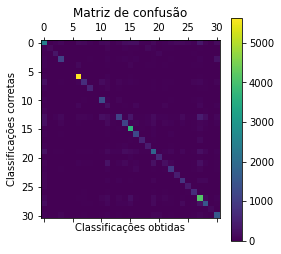

--------------------------------------------------------------------------------
................................................................................


('SGDClassifier',
 0.5858526865466538,
 9.548825740814209,
 0.04116249084472656,
 '                                             precision    recall  f1-score   support\n\n              Finanças Públicas e Orçamento       0.52      0.48      0.50      3763\n                        Estrutura Fundiária       0.50      0.53      0.52       811\n      Energia, Recursos Hídricos e Minerais       0.58      0.75      0.65      1635\n                   Arte, Cultura e Religião       0.55      0.46      0.50       709\n                      Administração Pública       0.51      0.45      0.48      5446\n                         Trabalho e Emprego       0.59      0.53      0.56      2851\n           Direito Penal e Processual Penal       0.60      0.73      0.66      1858\n                                   Economia       0.53      0.45      0.49      2540\n                                      Saúde       0.61      0.75      0.67      5483\n                                   Educação       0.69 

In [37]:
resultadoSGD =executarModeloClassificacao(
    SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"),
    X_train, 
    temas_treino,
    X_test, 
    temas_test, 
    target_names)


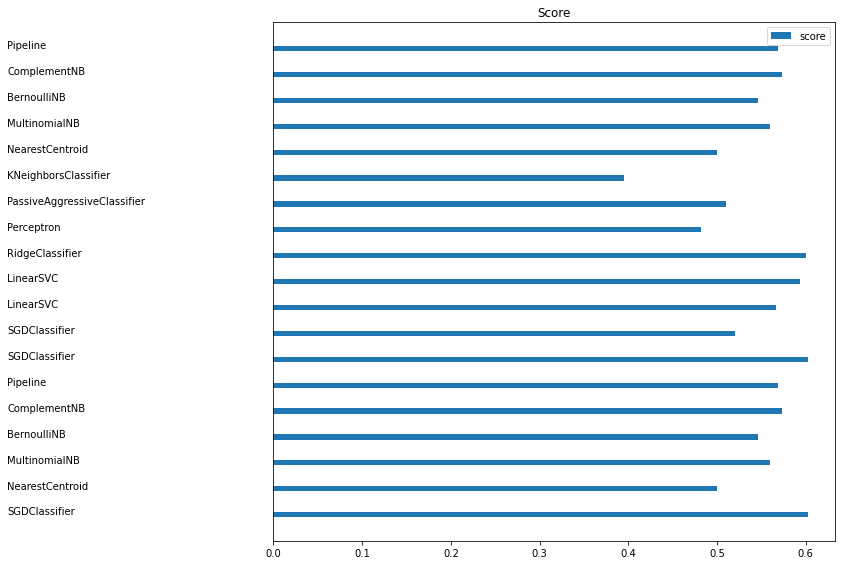

In [47]:
indices = np.arange(len(resultados))

results = [[x[i] for x in resultados] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score")
#plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
#plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()

In [59]:
dfResultado = pd.DataFrame(resultados,columns=['Modelo','Score','Tempo Treino','Tempo Teste','Matriz Confusão','Relatório'])
dfResultado.drop(['Matriz Confusão','Relatório'],inplace=True,axis=1)

dfResultado.sort_values(by=['Score'],ascending=False)

,Modelo,Score,Tempo Treino,Tempo Teste
0,SGDClassifier,0.602772,5.287374,0.037772
6,SGDClassifier,0.602274,5.361739,0.046895
10,RidgeClassifier,0.600247,35.448988,0.046856
9,LinearSVC,0.593686,76.364637,0.039250
4,ComplementNB,0.572918,0.679147,0.034712
17,ComplementNB,0.572918,0.579256,0.040202
5,Pipeline,0.569036,89.802416,0.051340
18,Pipeline,0.569036,92.412728,0.069036
8,LinearSVC,0.566408,41.837040,0.031223
2,MultinomialNB,0.559606,0.575230,0.032483
